In [50]:
import networkx as nx
import random as rnd
import matplotlib.pyplot as plt
import collections
from networkx.drawing.nx_pydot import graphviz_layout


In [51]:
def generateOr(G,n_sym,last_ix,pointer,level,parameter,parameter_used):
    num_ands = rnd.randint(2,3)
    G.add_node(last_ix+1,type='or',label='or')
    G.add_edge(pointer,last_ix+1)
    last_ix += 1
    pointer = last_ix
    for i in range(num_ands):
        last_ix,G = generateAnd(G,n_sym,last_ix,pointer,level,parameter,parameter_used,disj_used=True)
    return last_ix,G

def generateAnd(G,n_sym,last_ix,pointer,level,parameter=None,parameter_used=True,disj_used=False):
    disj = rnd.random() < 0.2 and not disj_used
    # generate Or node
    if disj:
        last_ix,G=generateOr(G,n_sym,last_ix,pointer,level,parameter,parameter_used)     
    # generate And node
    else:
        G.add_node(last_ix+1,type='and',label='and')
        G.add_edge(pointer,last_ix+1)
        last_ix += 1
        pointer = last_ix
        num_syms = rnd.randint(2,3)
        # generate And descendants
        for i in range(num_syms):
            subgoal= rnd.random() < 0.2 and level < 1
            # generate subtree
            if subgoal:
                G.add_node(last_ix+1,type='sub',label=str(last_ix + 1))
                G.add_edge(pointer,last_ix+1)    
                last_ix,G = generateAnd(G,n_sym,last_ix+1,last_ix+1,level+1,parameter,parameter_used,disj_used=False)
            # generate leafs
            else:
                # first leaf should be parameter if the molecule is parametrized
                if not parameter_used:
                    G.add_node(last_ix+1,type='par',label=str(parameter))                    
                    G.add_edge(pointer,last_ix+1) 
                # normal symbol
                else:
                    sym = rnd.randint(0,n_sym)
                    in_par = sym  // 5 == parameter
                    # the symbol may be sampled from the range of the parameter
                    if in_par:
                        G.add_node(last_ix+1,type='par',label=str(parameter))
                    else: G.add_node(last_ix+1,type='sym',label=str(sym))                    
                    G.add_edge(pointer,last_ix+1) 
                last_ix += 1
            parameter_used = True
    return last_ix, G
        

def generateMolecule():
    parametrized = rnd.random() < 0.2
    G = nx.DiGraph()
    last_ix = 21
    pointer = last_ix
    G.add_node(last_ix,type='root')
    parameter = None
    if parametrized:
        parameter = rnd.randint(0,4)
        ix,graph = generateAnd(G,20,last_ix,pointer,1,parameter,False)
    else:
        ix,graph = generateAnd(G,20,last_ix,pointer,1)
    return graph, parameter
    

In [52]:
def generateOr(G,n_sym,last_ix,pointer,level,parameter,parameter_used):
    num_ands = rnd.randint(2,3)
    G.add_node(last_ix+1,type='or',label='or')
    G.add_edge(pointer,last_ix+1)
    last_ix += 1
    pointer = last_ix
    for i in range(num_ands):
        last_ix,G = generateAnd(G,n_sym,last_ix,pointer,level,parameter,parameter_used,disj_used=True)
        parameter_used = True
    return last_ix,G


def generateAnd(G,n_sym,last_ix,pointer,level,parameter=None,parameter_used=True,disj_used=False):
    disj = rnd.random() < 0.2 and not disj_used
    # generate Or node
    if disj:
        last_ix,G=generateOr(G,n_sym,last_ix,pointer,level,parameter,parameter_used)     
    # generate And node
    else:
        G.add_node(last_ix+1,type='and',label='and')
        G.add_edge(pointer,last_ix+1)
        last_ix += 1
        pointer = last_ix
        num_syms = rnd.randint(2,3)
        # generate And descendants
        for i in range(num_syms):
            # first leaf should be parameter if the molecule is parametrized
            if not parameter_used:
                G.add_node(last_ix+1,type='par',label=str(parameter))                    
                G.add_edge(pointer,last_ix+1) 
            # normal symbol
            else:
                sym = rnd.randint(0,n_sym)
                in_par = (sym  // 5) == parameter
                # the symbol may be sampled from the range of the parameter
                if in_par:
                    G.add_node(last_ix+1,type='par',label=str(parameter))
                else: G.add_node(last_ix+1,type='sym',label=str(sym))                    
                G.add_edge(pointer,last_ix+1) 
            last_ix += 1
            parameter_used = True
    return last_ix, G
        

def generateMoleculePart(mol_id):
    parametrized = rnd.random() < 0.2
    G = nx.DiGraph()
    last_ix = mol_id
    pointer = last_ix
    G.add_node(last_ix,type='root',label = str(mol_id))
    parameter = None
    if parametrized:
        parameter = rnd.randint(0,4)
        ix,graph = generateAnd(G,20,last_ix,pointer,1,parameter,False)
    else:
        ix,graph = generateAnd(G,20,last_ix,pointer,1)
    return last_ix,graph, parameter

In [53]:
def adjoinSubtree(G,sG,leaf,root,num_replaced):
    G = G.copy()
    
    if num_replaced > 0:
        leaf_name = num_replaced*'g'+str(leaf)
        par = list(G.predecessors(leaf_name))[0]
        G.remove_node(leaf_name)
    else:
        par = list(G.predecessors(leaf))[0]
        G.remove_node(leaf)
    G = nx.union(G,sG,rename=('g','h'))
    par_name,root_name = 'g'+str(par),'h'+str(root)
    G.add_edge(par_name,root_name)
    G.nodes[root_name]['type']='sub'
    return G

def makeParametrized(G,parameters):
    parameters = list(set(parameters))
    leafs = [x for x in G.nodes(data=True) if G.out_degree(x[0])==0 and G.in_degree(x[0])]
    for l in leafs:
        p_range = int(l[1]['label'])//5
        if l[1]['type']=='sym' and p_range in parameters:
            p_ix = parameters.index(p_range)
            G.nodes[l[0]]['type']='par'
            G.nodes[l[0]]['label']=parameters[p_ix]
    return G


def generateMolecule(advanced_mols,basic_mols):
    params = []
    ix,G,p=rnd.choice(advanced_mols)
    leafs = [x for x in G.nodes(data=True) if G.out_degree(x[0])==0 and G.in_degree(x[0])]
    params.append(p)
    num_replaced = 0
    for l in leafs:
        replace = rnd.random()<0.4
        if replace:
            ix,sG,p=rnd.choice(basic_mols)
            params.append(p)
            G=adjoinSubtree(G,sG,l[0],ix,num_replaced)
            num_replaced+=1
    return params,makeParametrized(G,params)

In [54]:
basic_mols = [generateMoleculePart(100*i) for i in range(20)]
advanced_mols = [generateMoleculePart(1000*1) for i in range(20)]

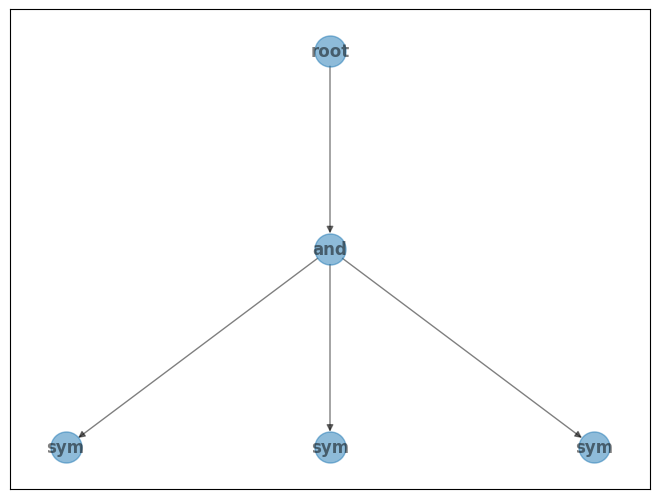

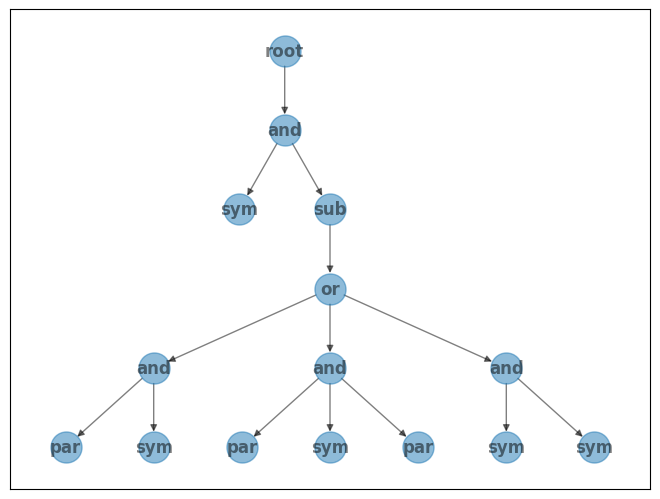

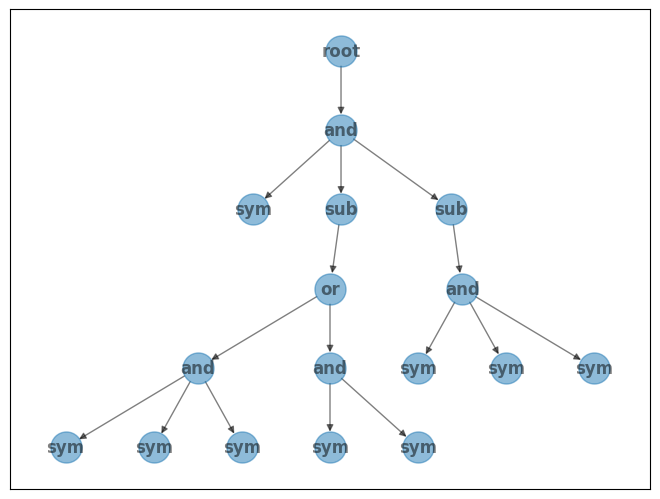

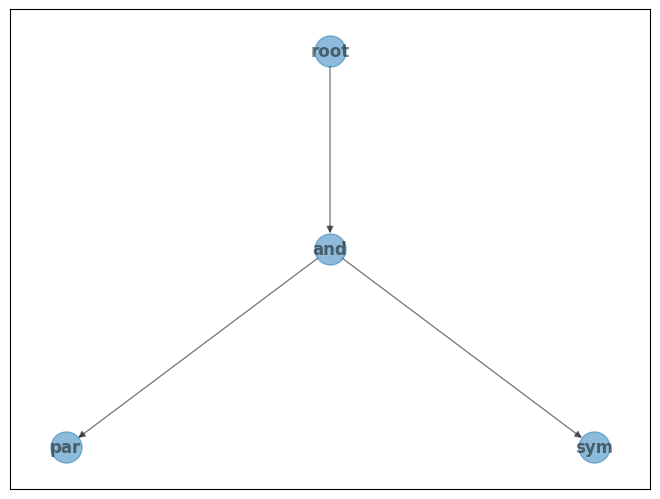

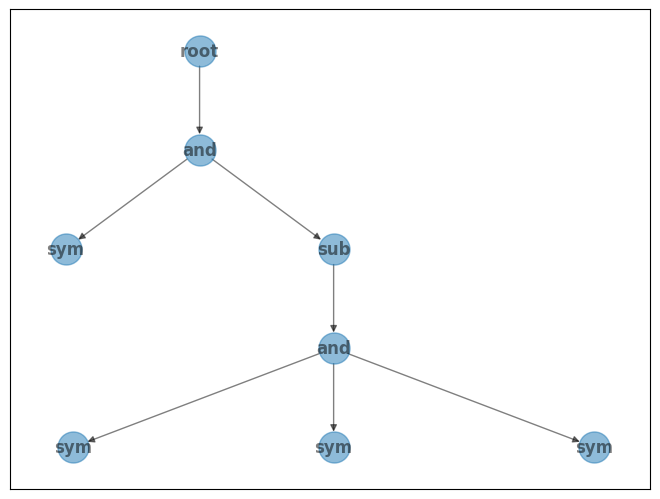

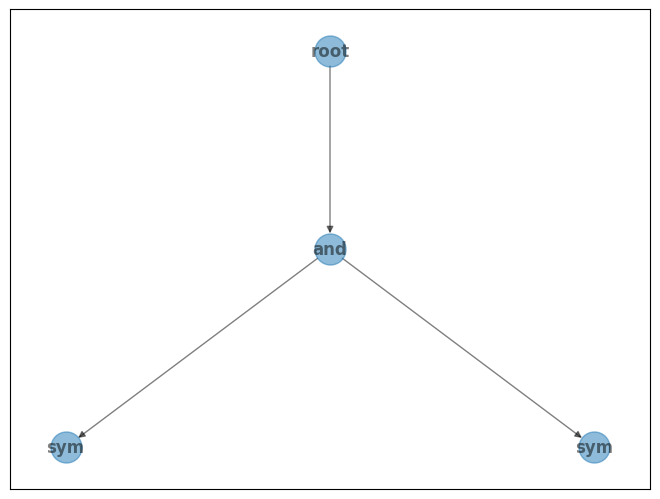

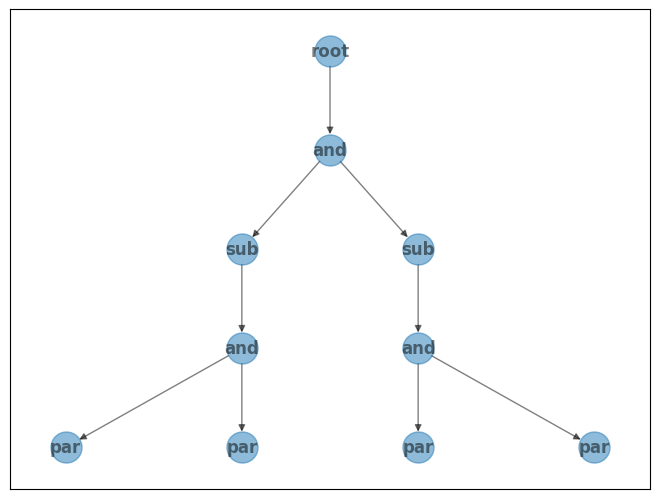

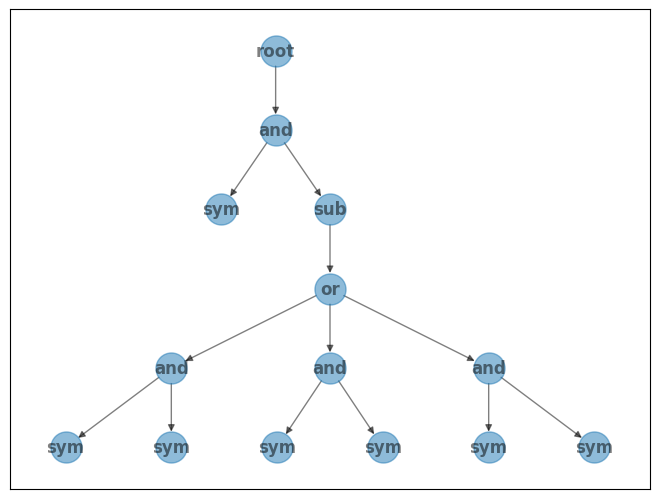

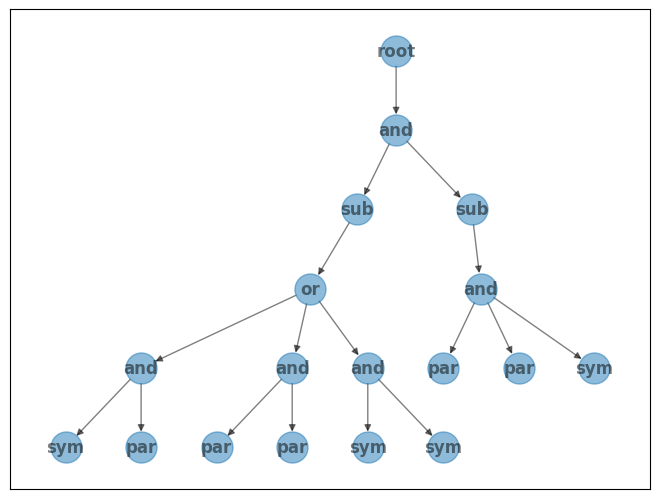

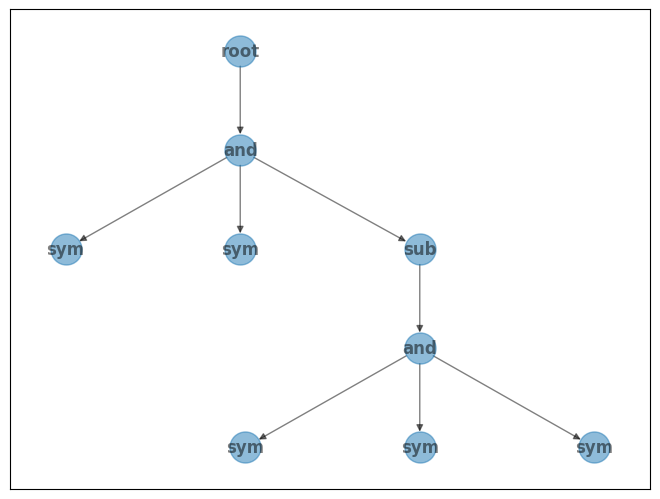

In [55]:
for i in range(10):
    params,G = generateMolecule(advanced_mols,basic_mols)
    pos = graphviz_layout(G, prog="dot")
    labels = nx.get_node_attributes(G, 'type') 
    nx.draw(G, pos=pos, labels=labels,
        node_size=500, alpha=0.5, font_weight="bold", arrows=True)
    plt.axis('on')
    plt.show()

In [56]:
mols = {i:generateMolecule(advanced_mols,basic_mols) for i in range(50)}

In [ ]:
print(mols[1])

In [ ]:
def generateInstanceData(mols):
    k = rnd.choice(range(len(mols)))
    params,G = mols[k]
    edges = [x for x in G.edges() if G.nodes[x[0]]['type']=='and']
    rnd.shuffle(edges)
    subgoals = [(None,params,G,k)]
    num_obs = rnd.randint(0,2)
    for i in range(num_obs):
        k = rnd.choice(range(len(mols)))
        params,sG=mols[k]
        subgoals.append((edges[i],params,sG,k))
    return subgoals

instancesData = [generateInstanceData(mols) for i in range(500)]

In [ ]:
instancesData[2]

In [ ]:
#ix,G,parameter = generateMolecule(1)
pos = graphviz_layout(G, prog="dot")
labels = nx.get_node_attributes(G, 'type') 
nx.draw(, pos=pos, with_labels=True,#labels=labels,
    node_size=500, alpha=0.5, font_weight="bold", arrows=True)
plt.axis('on')
plt.show()

In [ ]:
G_dict = {}
for x in range (0,30):
    G_dict[x]=nx.DiGraph()

In [ ]:
# atoms
def add_random_atoms(G_dict_param):
    and_node = "and"
    goal_node = "goal"
    for j in range(len(G_dict_param)):

        rnd_number1_group1 = rnd.randint(1, 5)

        G_dict_param[j].add_node(rnd_number1_group1, group=1)
        G_dict_param[j].add_node(and_node, type=1)
        G_dict_param[j].add_node(goal_node, type=3)
        G_dict_param[j].add_edge(rnd_number1_group1, and_node)
        G_dict_param[j].add_edge(and_node, goal_node)
        for k in range(rnd.randrange(1,5)):
            rnd_number2_group1 = rnd.randint(1, 5)
            G_dict_param[j].add_node(rnd_number2_group1)
            G_dict_param[j].add_edge(rnd_number2_group1, and_node)
    return G_dict_param

def create_new(n):
    and_node_1 = "and_1"
    and_node_2 = "and_2"
    and_nodes = [and_node_1, and_node_2]
    or_node = "or"
    goal_node = "goal"
    node_lst_to_connect = {}

    G_dict[n] = nx.DiGraph()

    G_dict[n].add_node(or_node, type=2)
    G_dict[n].add_node(and_node_1, type=1)
    G_dict[n].add_node(and_node_2, type=1)
    G_dict[n].add_node(goal_node, type=3)

    G_dict[n].add_edge(and_node_1, or_node)
    G_dict[n].add_edge(and_node_2, or_node)
    G_dict[n].add_edge(or_node, goal_node)
    counter=0
    counter2=0

    while len(G_dict[n].in_edges(and_node_1)) < rnd.randint(2,3):
        rnd_number1_group1 = rnd.randint(1, 5)
        G_dict[n].add_node(rnd_number1_group1, group=1)
        node_lst_to_connect[counter] = rnd_number1_group1
        node_to_add_1 = node_lst_to_connect.get(counter)
        counter += 1
        G_dict[n].add_edge(node_to_add_1, and_node_1)

    while len(G_dict[n].in_edges(and_node_2)) < rnd.randint(2,3):
        rnd_number2_group1 = rnd.randint(1, 5)
        G_dict[n].add_node(rnd_number2_group1, group=1)
        node_lst_to_connect[counter] = rnd_number2_group1
        node_to_add_1 = node_lst_to_connect.get(counter)
        counter2 += 1
        G_dict[n].add_edge(node_to_add_1, and_node_2)

    return G_dict[n]

def check_if_2_same_graphs_and_remove():
    for k in range(len(G_dict)):
        for j in range(len(G_dict)):
            if G_dict[k].nodes == G_dict[j].nodes and k != j:
                    del G_dict[j]
                    G_dict[j] = create_new(j)

In [ ]:
G_dict = add_random_atoms(G_dict)
check_if_2_same_graphs_and_remove()

In [ ]:
for i in range(len(G_dict)):
    nx.draw(G_dict[i], with_labels=True,
        node_size=1500, alpha=0.5, font_weight="bold", arrows=True,
        connectionstyle='arc3, rad = 0.1')
    print(i)
    plt.axis('on')
    plt.show()

0


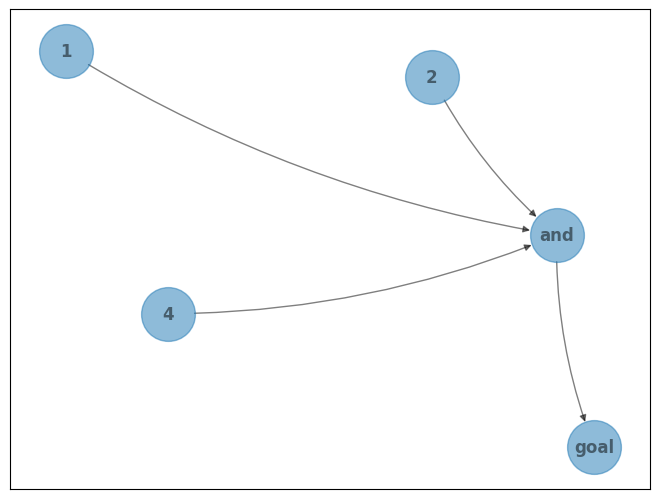

1


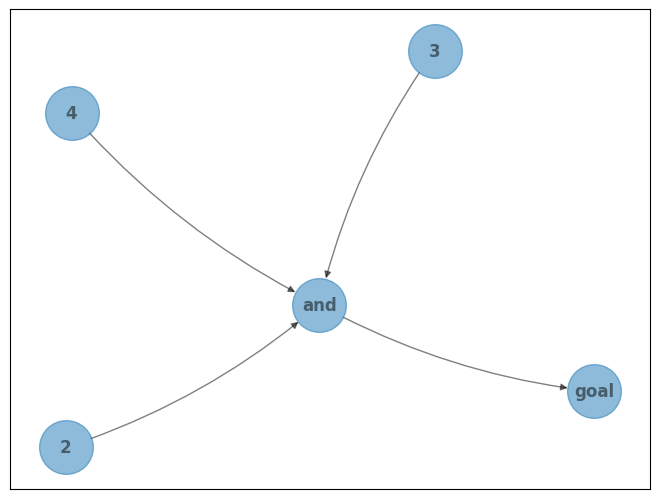

2


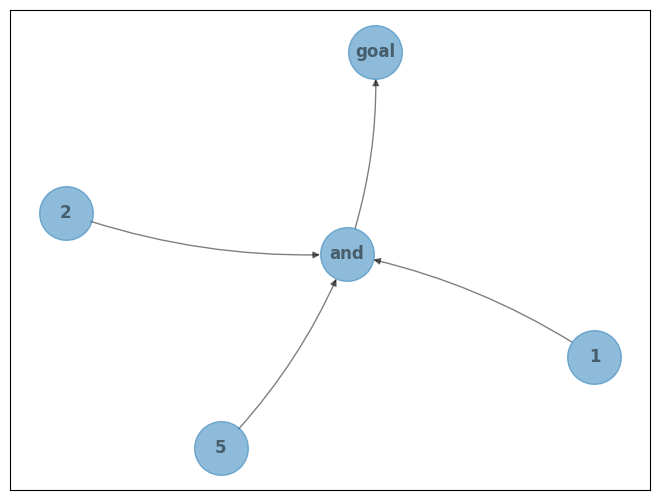

3


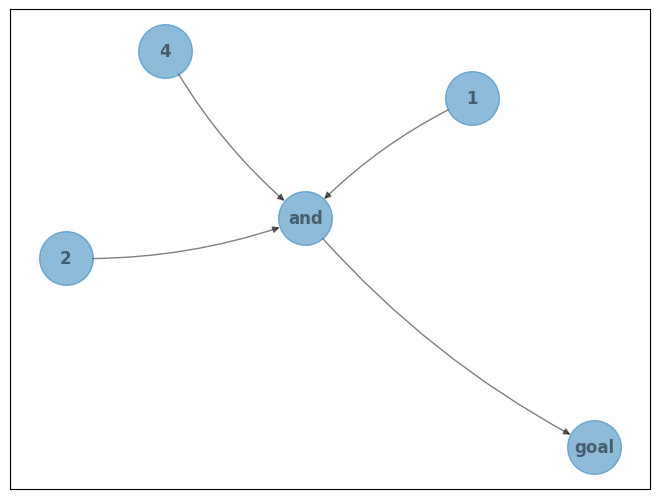

4


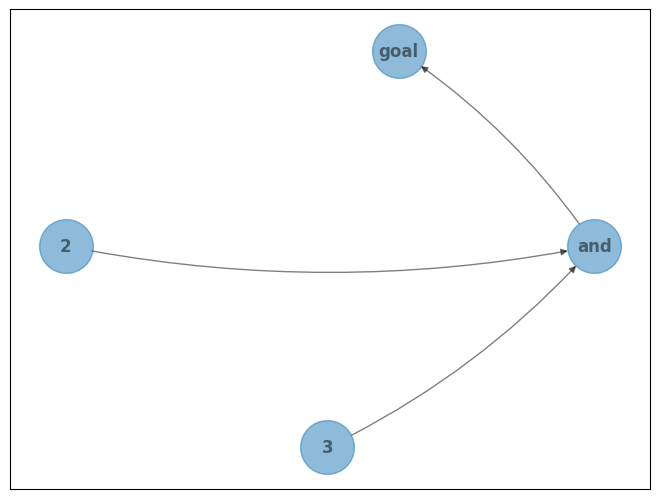

5


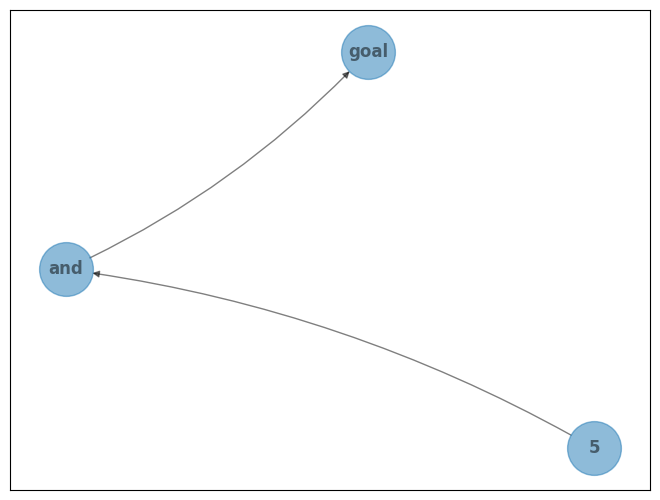

6


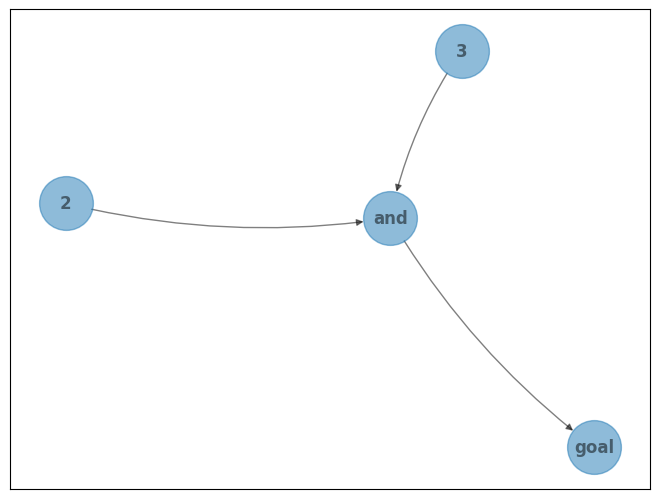

7


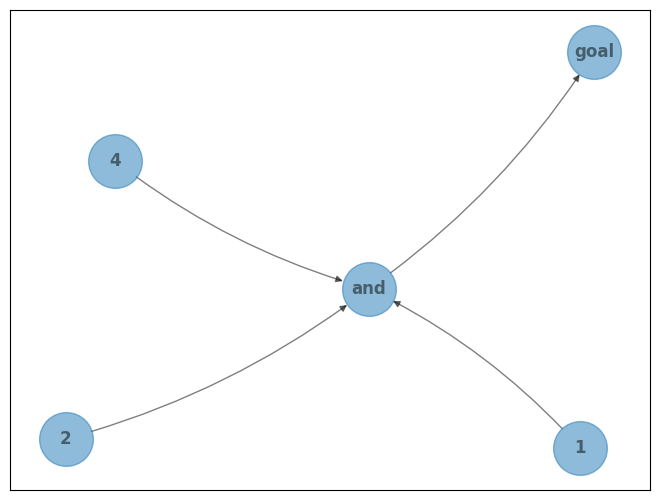

8


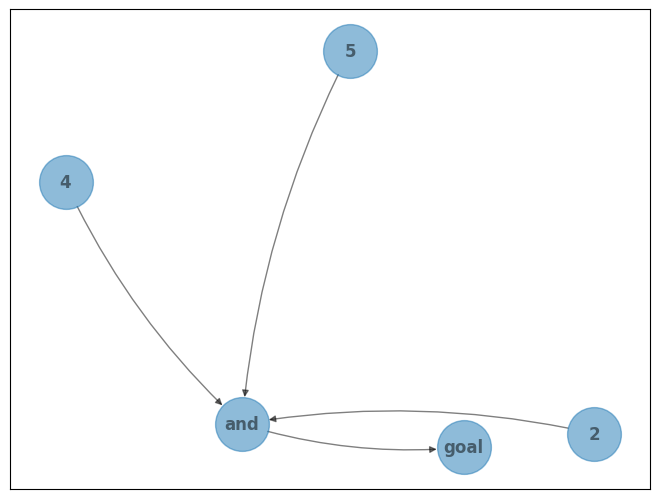

9


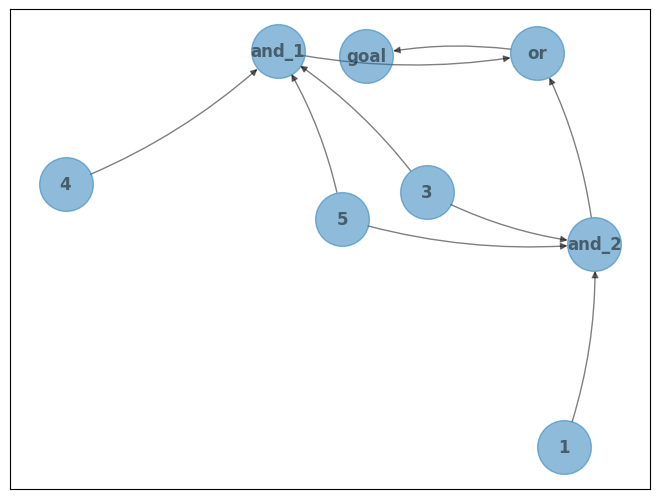

10


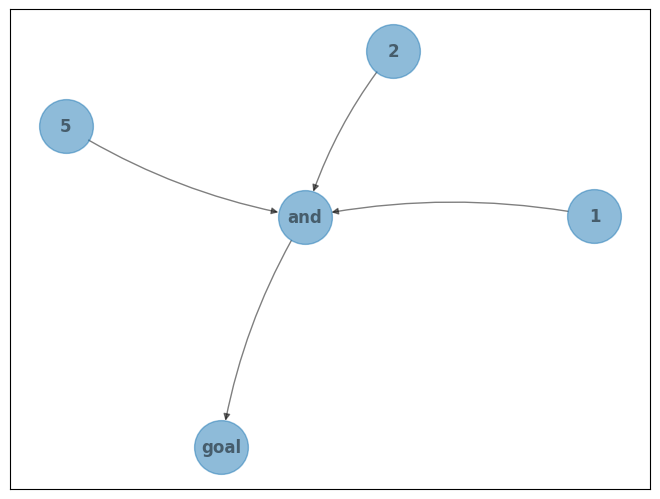

11


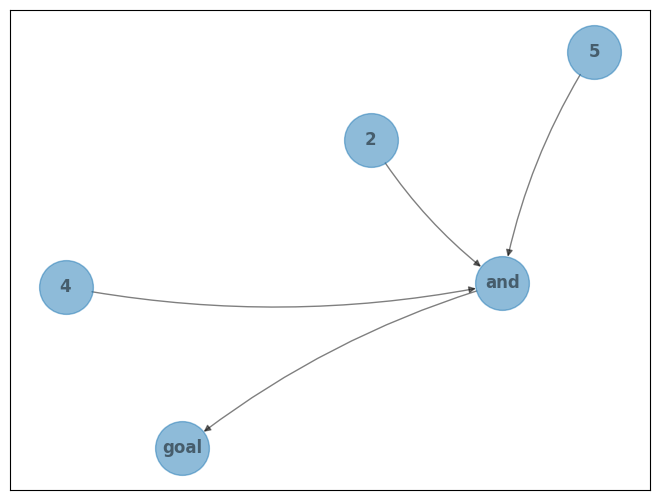

12


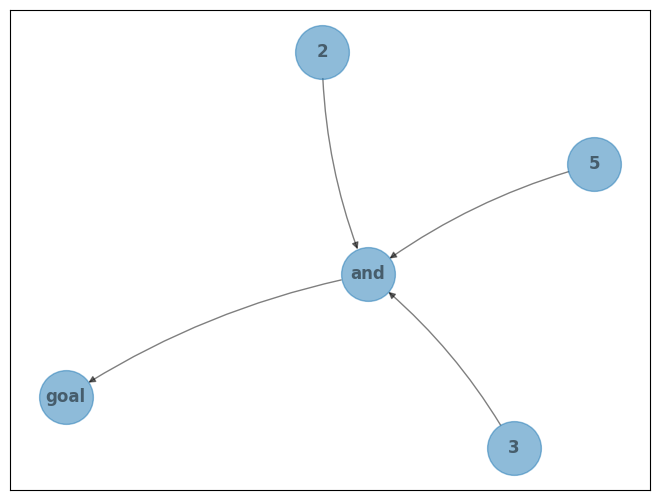

13


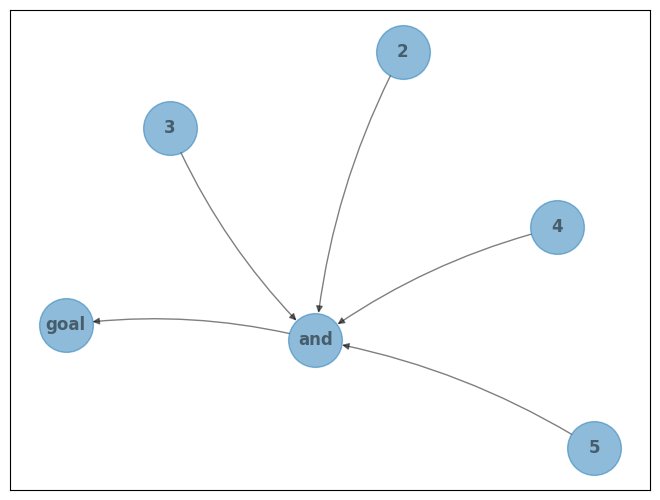

14


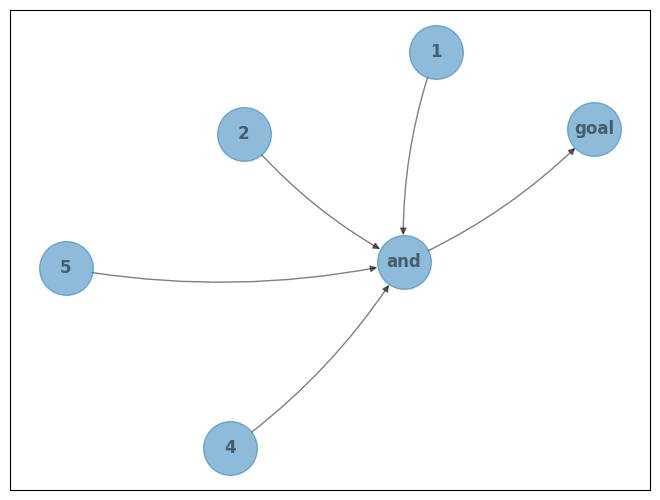

15


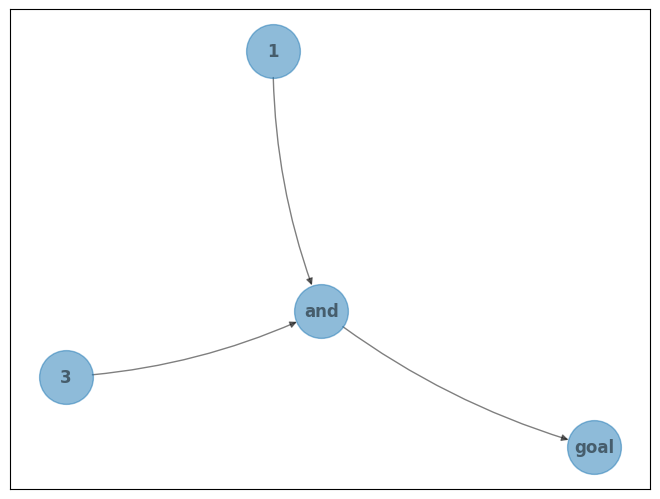

16


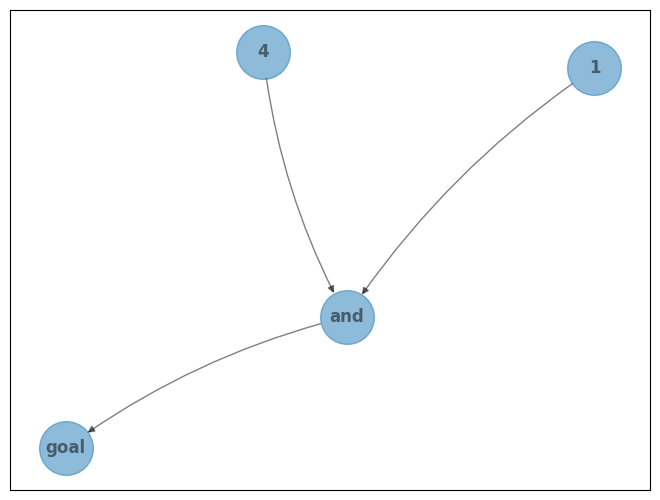

17


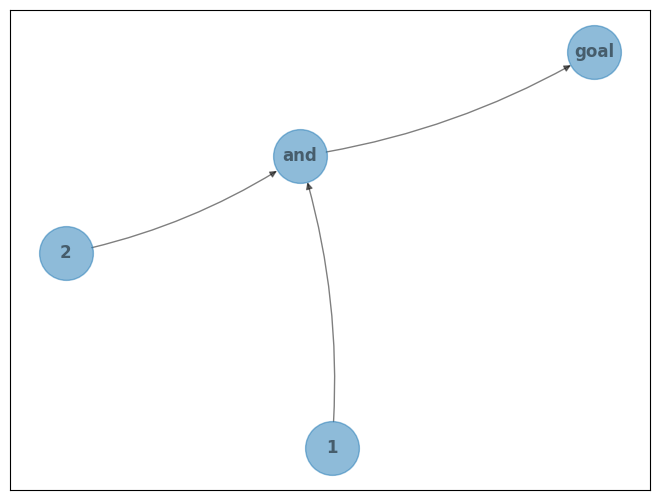

18


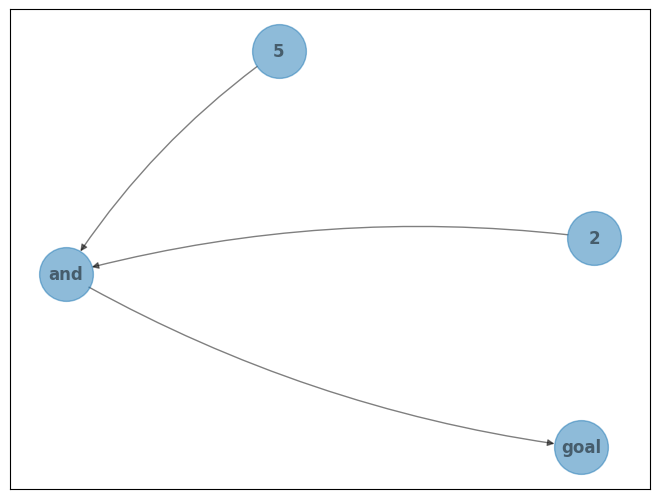

19


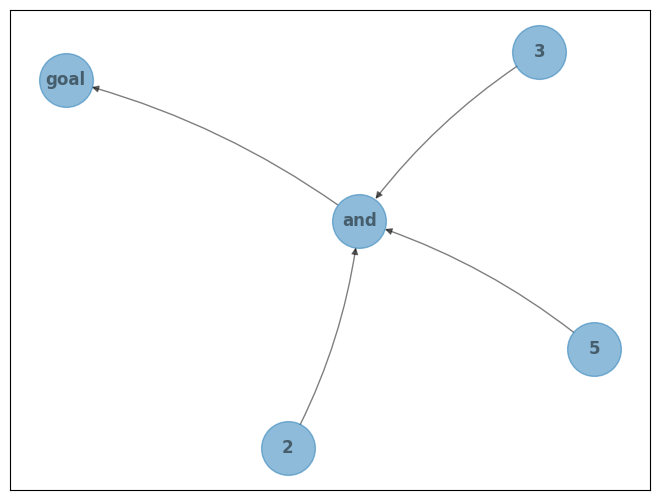

20


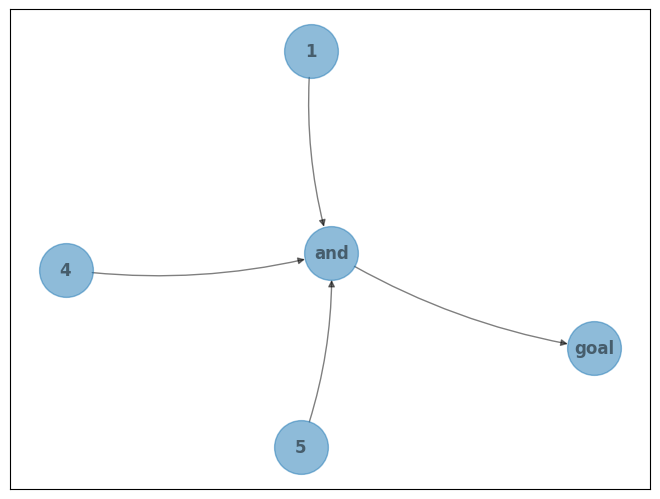

21


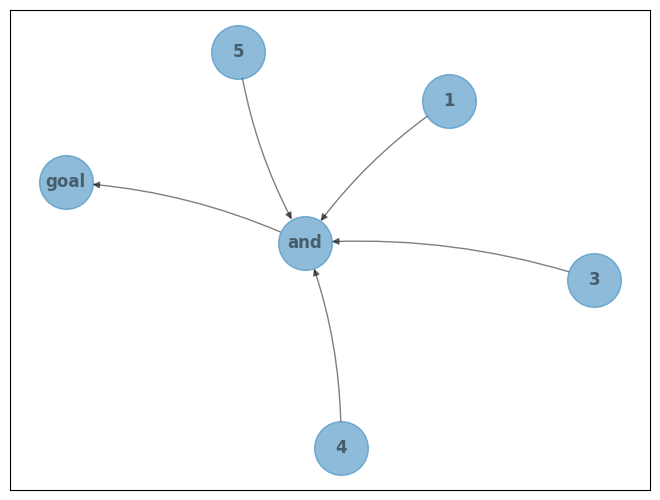

22


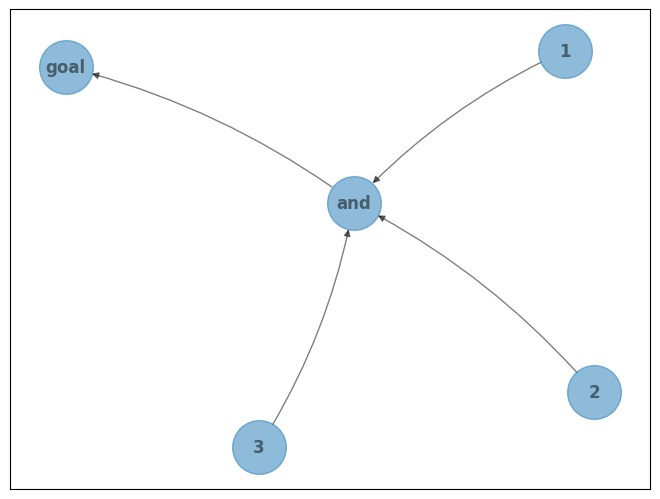

23


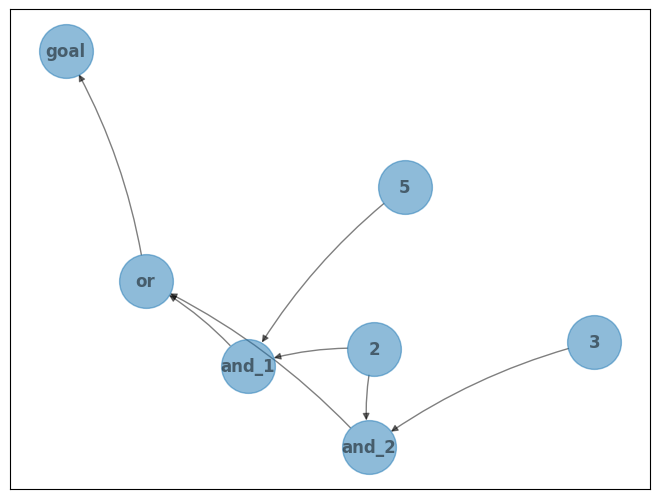

24


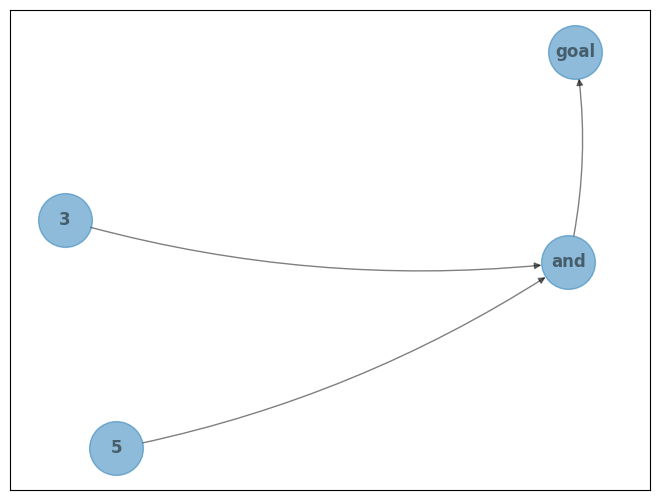

25


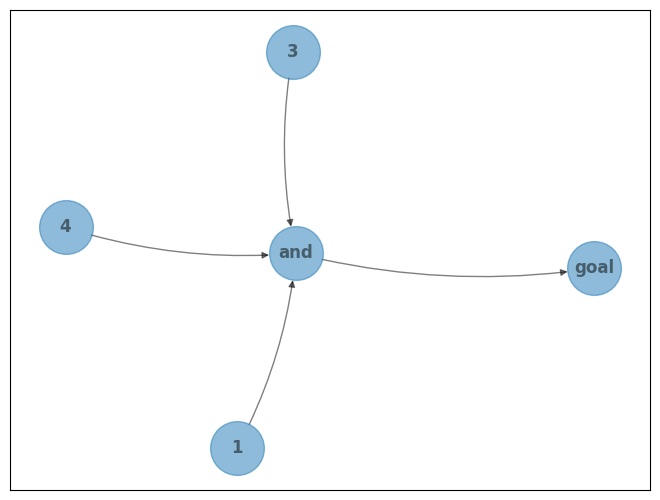

26


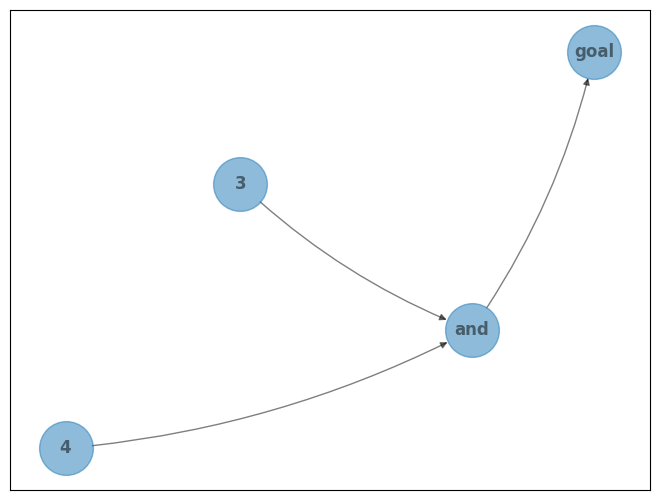

27


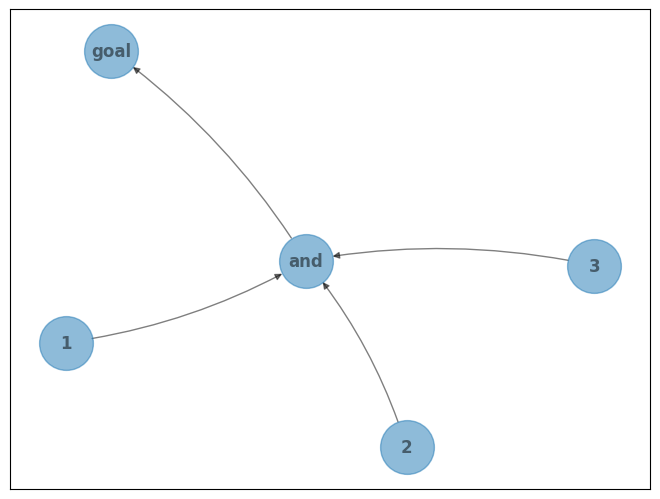

28


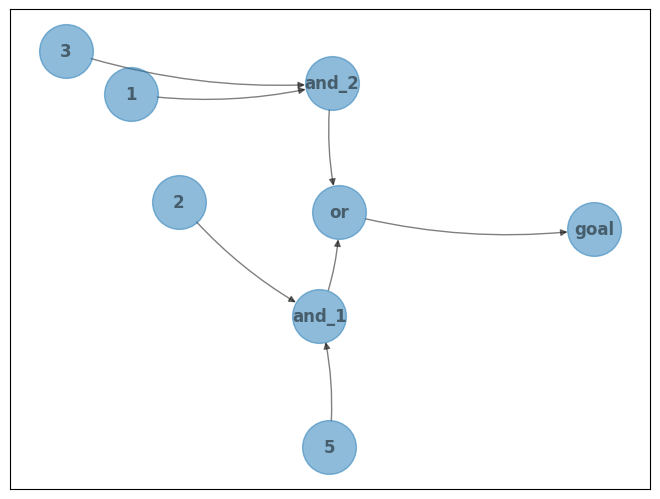

29


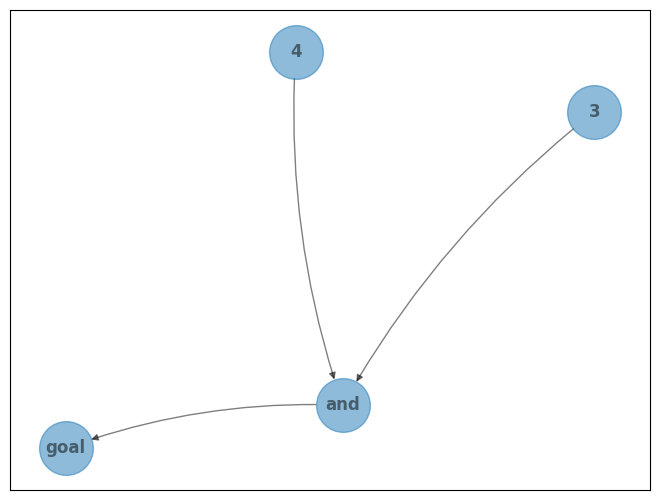

In [26]:
for i in range(len(G_dict)):
    nx.draw(G_dict[i], with_labels=True,
        node_size=1500, alpha=0.5, font_weight="bold", arrows=True,
        connectionstyle='arc3, rad = 0.1')
    print(i)
    plt.axis('on')
    plt.show()